# DATA EXPLORATION & ANALYSIS FOR AGROFOOD_CO2_EMISSIONS DATASET

In [170]:
#importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")
from sklearn.neighbors import LocalOutlierFactor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import KFold
from sklearn.svm import SVR
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score
import torch.utils.data as data_utils
from sklearn.cluster import KMeans


## Data Analysis

In [6]:
df = pd.read_csv('/content/drive/MyDrive/Agrofood_co2_emission.csv')
df.dropna(inplace=True)

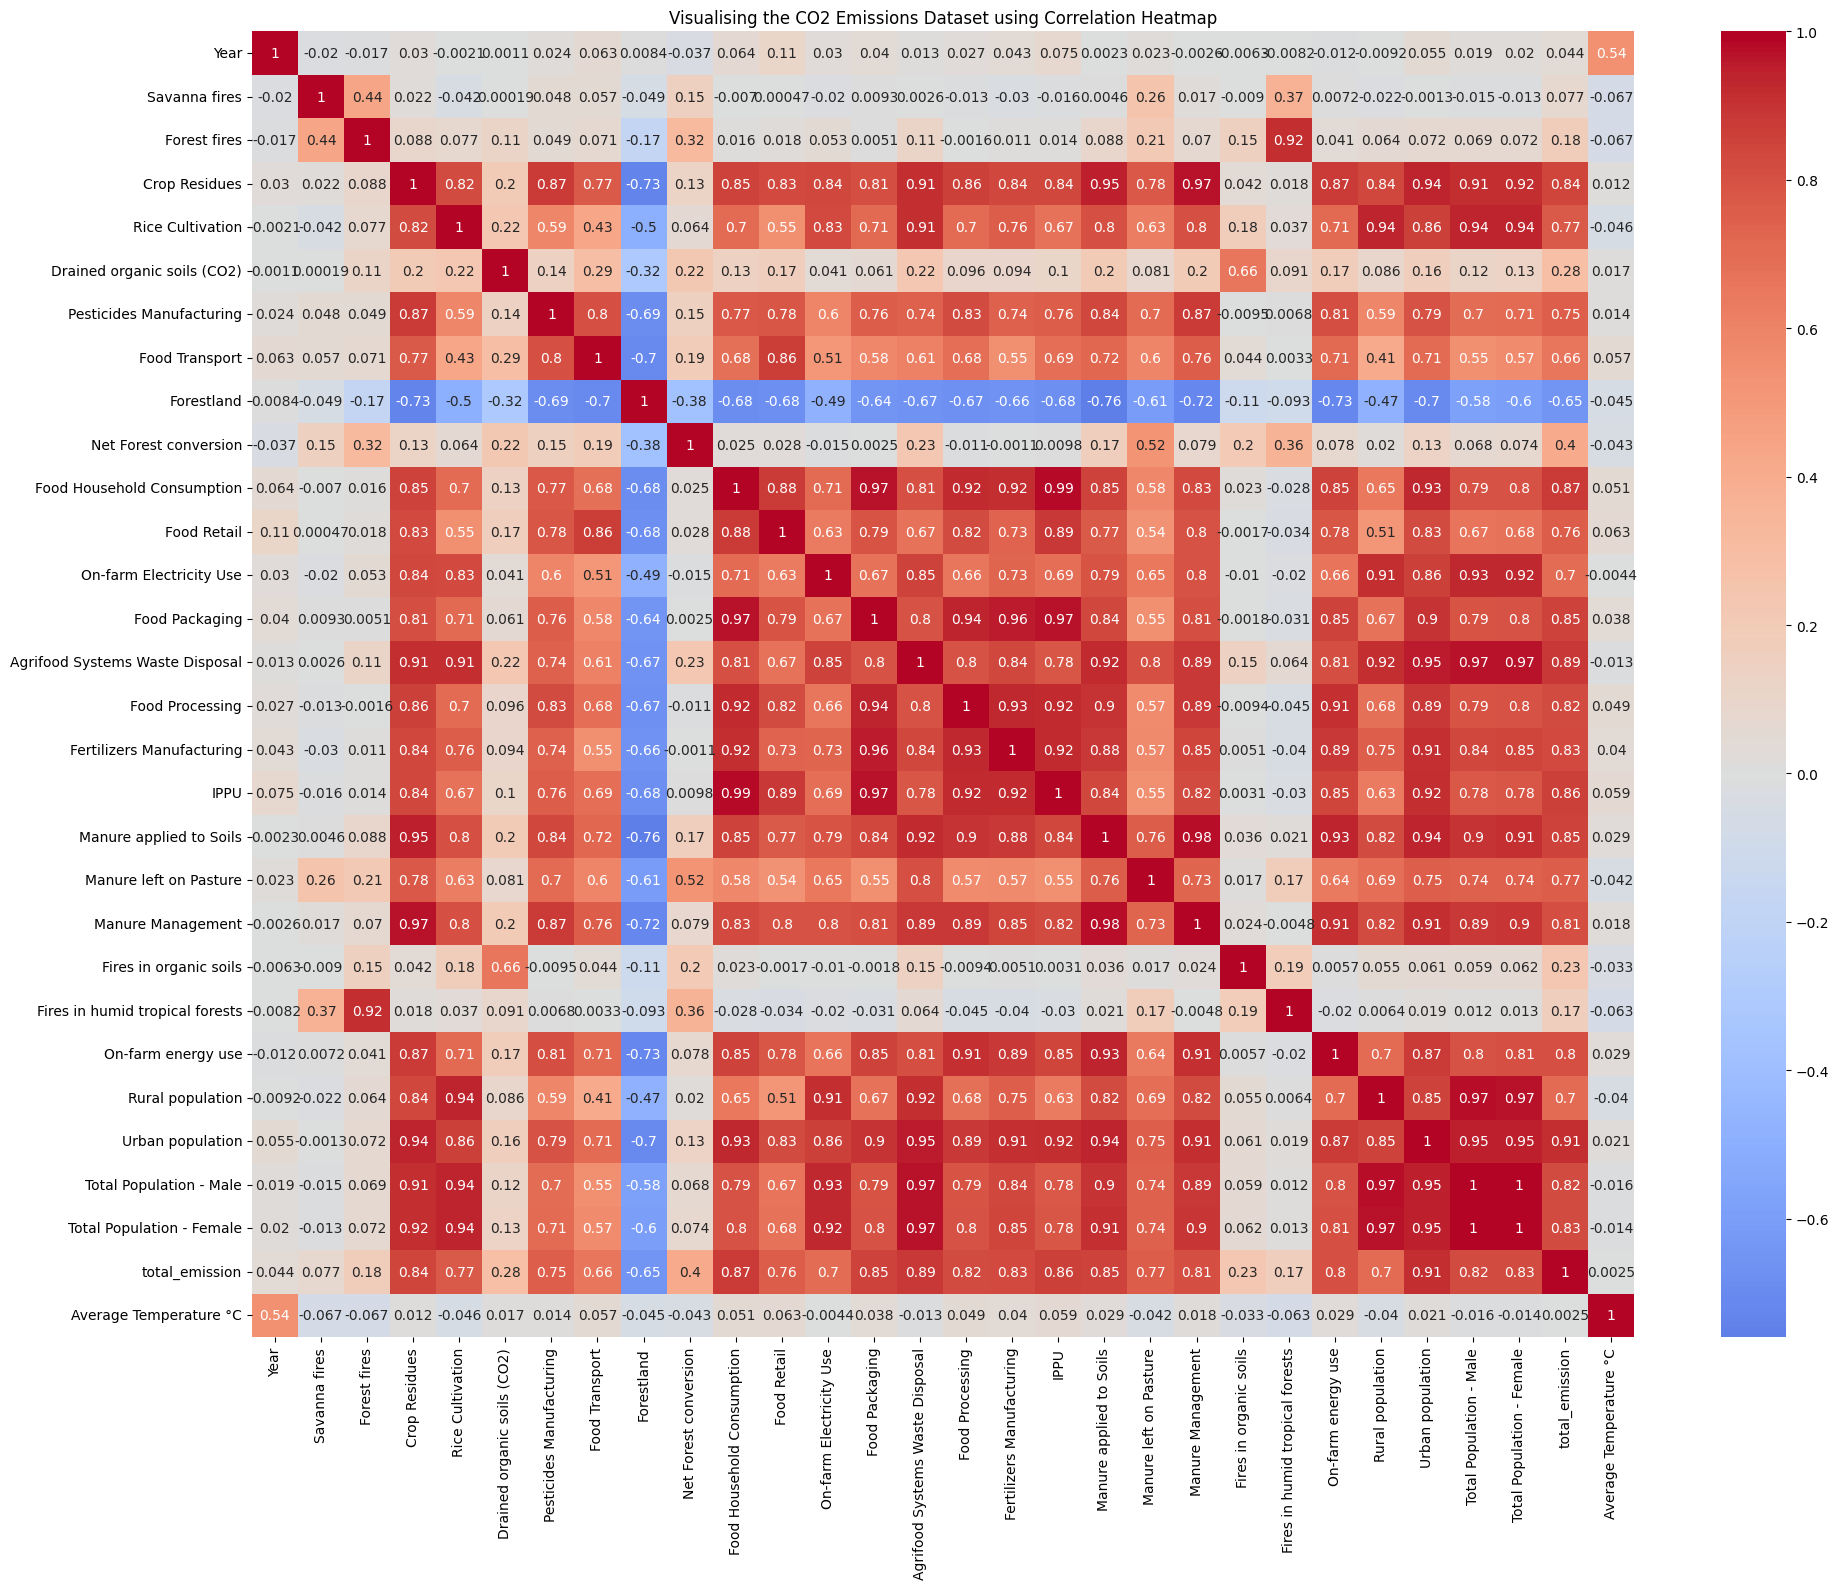

In [ ]:
plt.figure(figsize=(20, 16))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title("Visualising the CO2 Emissions Dataset using Correlation Heatmap")
plt.tight_layout()
plt.show()

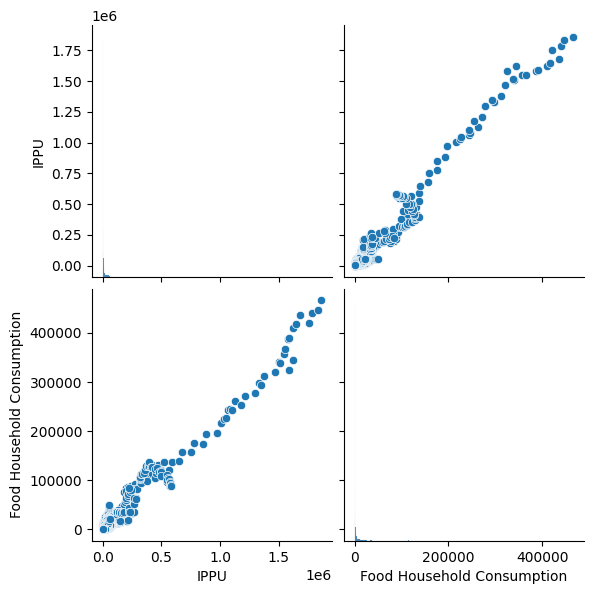

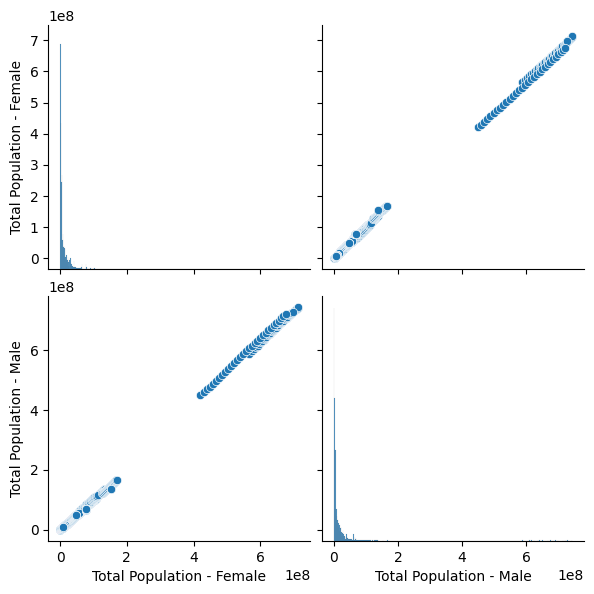

In [ ]:
correlation_matrix = df.corr()
threshold = 0.99

pairs = []
length = len(correlation_matrix.columns);
for i in range(length):
    for j in range(i):
        if round(abs(correlation_matrix.iloc[i, j]), 2) >= threshold:
            pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j]))

figure_size = (15, 15)
for pair in pairs:
    sns.pairplot(data=df, vars=pair, height=3)
    plt.show()

## Model

In [184]:
class Model:

  def __init__(self, model, parameters, kf):
    self.rs = model
    self.parameters = parameters
    self.df = pd.read_csv('/content/drive/MyDrive/Agrofood_co2_emission.csv')
    self.df.dropna(inplace=True)
    self.kf = kf

  def outlier_removal(self, X, y):

    # Fit the model on the training data
    outliers_train = self.parameters['outlier_detector'].fit_predict(X)

    # Identify and filter out outliers in the training set
    mask_train = outliers_train != -1
    X = X[mask_train]
    y = y[mask_train]

    # Print the number of outliers in the training set
    number_outliers_train = len(outliers_train[outliers_train == -1])
    print("Number of outliers in the training set:", number_outliers_train)
    return X, y

  def preprocessing(self):
    correlation_matrix = self.df.corr()
    threshold = 0.99
    correlated_features = set()

    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if round(abs(correlation_matrix.iloc[i, j]), 2) >= threshold:
                colname = correlation_matrix.columns[i]
                correlated_features.add(colname)

    if(self.parameters["num_PCA_comp"]==-1):
      print("Number of Highly correlated features removes: ", len(correlated_features))
      print("Features Removed: ", correlated_features)
      print("")

    self.df.drop(columns=correlated_features, inplace=True)
    correlation_matrix = self.df.corr()

    self.X = self.df.iloc[:,0:-1]
    self.Y = self.df.iloc[:,-1]

    if(self.parameters["encoding"]=="OneHot"):
      self.X = pd.get_dummies(self.X, columns=self.X.select_dtypes(include=['object']).columns)
    elif(self.parameters["encoding"]=="Label"):
      self.X["Area"] = LabelEncoder().fit_transform(self.X["Area"])

  def training_validation(self):
    self.preprocessing()
    self.X = self.X.to_numpy()
    self.Y = self.Y.to_numpy()
    self.mae_train, self.rmse_train, self.r2_train = [], [], []
    self.mae_val, self.rmse_val, self.r2_val = [], [], []

    for i, (train_index, test_index) in enumerate(self.kf.split(self.X)):

      X_train = np.array([self.X[i] for i in train_index])
      Y_train = np.array([self.Y[i] for i in train_index])

      if(self.parameters['outlier_detector']!=None):
        X_train, Y_train = self.outlier_removal(X_train, Y_train)

      X_val = np.array([self.X[i] for i in test_index])
      Y_val = np.array([self.Y[i] for i in test_index])

      if(self.parameters['additional_feature']):
        kmeans = KMeans(n_clusters=3, random_state=42)
        kmeans.fit(X_train)
        cluster_id_train = kmeans.predict(X_train)
        cluster_id_val = kmeans.predict(X_val)
        X_train = np.concatenate((X_train, np.array([cluster_id_train]).T), axis=1)
        X_val = np.concatenate((X_val, np.array([cluster_id_val]).T), axis=1)

      ss=StandardScaler()
      X_train = ss.fit_transform(X_train)
      X_val = ss.transform(X_val)

      if(self.parameters["num_PCA_comp"]!=-1):
        pca = PCA()
        X_train = pca.fit_transform(X_train)
        X_val = pca.transform(X_val)


      self.rs.fit(X_train, Y_train)
      Y_train_pred = self.rs.predict(X_train)
      Y_val_pred = self.rs.predict(X_val)

      self.mae_val.append(mean_absolute_error(Y_val, Y_val_pred))
      self.mae_train.append(mean_absolute_error(Y_train, Y_train_pred))

      self.rmse_val.append(np.sqrt(mean_squared_error(Y_val, Y_val_pred)))
      self.rmse_train.append(np.sqrt(mean_squared_error(Y_train, Y_train_pred)))

      self.r2_val.append(r2_score(Y_val, Y_val_pred))
      self.r2_train.append(r2_score(Y_train, Y_train_pred))

    if(self.parameters["num_PCA_comp"]==-1):
      print("Train mean absolute error: ", np.average(self.mae_train))
      print("Train root mean squared error: ", np.average(self.rmse_train))
      print("Train r2-score:", np.average(self.r2_train))
      print("")
      print("Validation mean absolute error: ", np.average(self.mae_val))
      print("Validation root mean squared error: ", np.average(self.rmse_val))
      print("Validation r2-score:", np.average(self.r2_val))
      print("")
    else:
      return np.average(self.mae_train), np.average(self.rmse_train), np.average(self.r2_train), np.average(self.mae_val), np.average(self.rmse_val), np.average(self.r2_val)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [162]:
num_folds = 5

In [163]:
kf = KFold(n_splits=num_folds, random_state=42, shuffle=True)

## One Hot Encoding, No PCA

#### Random Forest Regressor

In [ ]:
model = Model(model = RandomForestRegressor(), parameters = {"encoding": "OneHot", "num_PCA_comp": -1}, kf = kf)

In [ ]:
model.training_validation()

Number of Highly correlated features removes:  2
Features Removed:  {'IPPU', 'Total Population - Female'}

Train mean absolute error:  0.10287041146008265
Train root mean squared error:  0.14160392856782425
Train r2-score: 0.9404860067867963

Validation mean absolute error:  0.27553908309697783
Validation root mean squared error:  0.373812683361251
Validation r2-score: 0.5844977903433669



#### Linear Regression

In [ ]:
model = Model(model = LinearRegression(), parameters = {"encoding": "OneHot", "num_PCA_comp": -1}, kf = kf)

In [ ]:
model.training_validation()

Number of Highly correlated features removes:  2
Features Removed:  {'IPPU', 'Total Population - Female'}

Train mean absolute error:  0.2950927547697523
Train root mean squared error:  0.3998556434486456
Train r2-score: 0.5254390712802296

Validation mean absolute error:  232259863.91941524
Validation root mean squared error:  4952865265.146614
Validation r2-score: -1.7709187045609544e+20



#### Gradient Boosting Regressor

In [ ]:
model = Model(model = GradientBoostingRegressor(), parameters = {"encoding": "OneHot", "num_PCA_comp": -1}, kf = kf)

In [ ]:
model.training_validation()

Number of Highly correlated features removes:  2
Features Removed:  {'IPPU', 'Total Population - Female'}

Train mean absolute error:  0.2728104826906141
Train root mean squared error:  0.36495467404161086
Train r2-score: 0.60466841279981

Validation mean absolute error:  0.2972425587279775
Validation root mean squared error:  0.39860999464426106
Validation r2-score: 0.5274789841083053



#### Adaboost Regressor

In [ ]:
model = Model(model = AdaBoostRegressor(), parameters = {"encoding": "OneHot", "num_PCA_comp": -1}, kf = kf)

In [ ]:
model.training_validation()

Number of Highly correlated features removes:  2
Features Removed:  {'IPPU', 'Total Population - Female'}

Train mean absolute error:  0.3453297827066076
Train root mean squared error:  0.4393316993019708
Train r2-score: 0.4270921046064844

Validation mean absolute error:  0.35217749597048725
Validation root mean squared error:  0.4566825149109758
Validation r2-score: 0.3797962259817684



#### XGB Regressor

In [ ]:
model = Model(model = XGBRegressor(), parameters = {"encoding": "OneHot", "num_PCA_comp": -1}, kf = kf)

In [ ]:
model.training_validation()

Number of Highly correlated features removes:  2
Features Removed:  {'IPPU', 'Total Population - Female'}

Train mean absolute error:  0.10916482868573203
Train root mean squared error:  0.14488503152712146
Train r2-score: 0.9376481305328934

Validation mean absolute error:  0.27711783891769803
Validation root mean squared error:  0.37425664830055466
Validation r2-score: 0.5834190618025235



#### Lasso Regressor

In [ ]:
# Best Alpha found is 0.0001
alphas = [0.0, 0.0001, 0.001, 0.01, 0.1, 1.0]

In [ ]:
for alpha in alphas:
  model = Model(model = Lasso(alpha=alpha), parameters = {"encoding": "OneHot", "num_PCA_comp": -1}, kf = kf)
  print("Alpha: ", alpha)
  model.training_validation()
  print("")

Alpha:  0.0
Number of Highly correlated features removes:  2
Features Removed:  {'IPPU', 'Total Population - Female'}

Train mean absolute error:  0.2951277859972585
Train root mean squared error:  0.4000984413172426
Train r2-score: 0.5248619942045201

Validation mean absolute error:  0.30919683103283296
Validation root mean squared error:  0.4189132755993882
Validation r2-score: 0.4778115625164583


Alpha:  0.0001
Number of Highly correlated features removes:  2
Features Removed:  {'IPPU', 'Total Population - Female'}

Train mean absolute error:  0.294969284805219
Train root mean squared error:  0.40019814528855147
Train r2-score: 0.5246250482907234

Validation mean absolute error:  0.3088952358368837
Validation root mean squared error:  0.41883209269541605
Validation r2-score: 0.4780155157489677


Alpha:  0.001
Number of Highly correlated features removes:  2
Features Removed:  {'IPPU', 'Total Population - Female'}

Train mean absolute error:  0.29644936974311237
Train root mean squa

#### Ridge Regressor

In [ ]:
# Best Alpha 1.0
alphas = [0.0, 0.0001, 0.001, 0.01, 0.1, 1.0]

In [ ]:
for alpha in alphas:
  model = Model(model = Ridge(alpha=alpha), parameters = {"encoding": "OneHot", "num_PCA_comp": -1}, kf = kf)
  print("Alpha: ", alpha)
  model.training_validation()
  print("")

Alpha:  0.0
Number of Highly correlated features removes:  2
Features Removed:  {'IPPU', 'Total Population - Female'}

Train mean absolute error:  0.2949476921374198
Train root mean squared error:  0.399718856488112
Train r2-score: 0.5257627907122122

Validation mean absolute error:  674690638.1928765
Validation root mean squared error:  14390236215.845821
Validation r2-score: -2.132566697598497e+21


Alpha:  0.0001
Number of Highly correlated features removes:  2
Features Removed:  {'IPPU', 'Total Population - Female'}

Train mean absolute error:  0.29495060668687445
Train root mean squared error:  0.3997183305844969
Train r2-score: 0.5257640413031642

Validation mean absolute error:  0.3095805551721883
Validation root mean squared error:  0.418832426063226
Validation r2-score: 0.4780088648329631


Alpha:  0.001
Number of Highly correlated features removes:  2
Features Removed:  {'IPPU', 'Total Population - Female'}

Train mean absolute error:  0.2949451108895986
Train root mean squar

#### Support Vector Machine

##### RBF kernel

In [ ]:
model = Model(model = SVR(kernel='rbf'), parameters = {"encoding": "OneHot", "num_PCA_comp": -1}, kf = kf)

In [ ]:
model.training_validation()

Number of Highly correlated features removes:  2
Features Removed:  {'IPPU', 'Total Population - Female'}

Train mean absolute error:  0.2843938906100245
Train root mean squared error:  0.39708073191154303
Train r2-score: 0.5319924123983014

Validation mean absolute error:  0.30732937101046
Validation root mean squared error:  0.4210538797445473
Validation r2-score: 0.4724346431298181



##### Linear kernel

In [ ]:
model = Model(model = SVR(kernel='linear'), parameters = {"encoding": "OneHot", "num_PCA_comp": -1}, kf = kf)

In [ ]:
model.training_validation()

Number of Highly correlated features removes:  2
Features Removed:  {'IPPU', 'Total Population - Female'}

Train mean absolute error:  0.29256213430108147
Train root mean squared error:  0.4042210803642064
Train r2-score: 0.5150240724173237

Validation mean absolute error:  0.3107138263430083
Validation root mean squared error:  0.4224501515245084
Validation r2-score: 0.4690411891271259



##### Poly Kernel

In [ ]:
model = Model(model = SVR(kernel='poly'), parameters = {"encoding": "OneHot", "num_PCA_comp": -1}, kf = kf)

In [ ]:
model.training_validation()

Number of Highly correlated features removes:  2
Features Removed:  {'IPPU', 'Total Population - Female'}

Train mean absolute error:  0.3166739404118014
Train root mean squared error:  0.44111258379130386
Train r2-score: 0.42246076329764365

Validation mean absolute error:  0.34430941236322743
Validation root mean squared error:  0.469899275220409
Validation r2-score: 0.3431926429694059



##### Sigmoid Kernel

In [ ]:
model = Model(model = SVR(kernel='sigmoid'), parameters = {"encoding": "OneHot", "num_PCA_comp": -1}, kf = kf)

In [ ]:
model.training_validation()

Number of Highly correlated features removes:  2
Features Removed:  {'IPPU', 'Total Population - Female'}

Train mean absolute error:  1.217530884707107
Train root mean squared error:  5.6825994693742174
Train r2-score: -95.38572974814818

Validation mean absolute error:  1.2963698325654822
Validation root mean squared error:  5.77105769668231
Validation r2-score: -107.04901909313367



## Label Encoding, No PCA

#### Random Forest Regressor

In [ ]:
model = Model(model = RandomForestRegressor(), parameters = {"encoding": "Label", "num_PCA_comp": -1}, kf = kf)

In [ ]:
model.training_validation()

Number of Highly correlated features removes:  2
Features Removed:  {'IPPU', 'Total Population - Female'}

Train mean absolute error:  0.10306235846965808
Train root mean squared error:  0.14143789890486907
Train r2-score: 0.940622892150947

Validation mean absolute error:  0.27693968828487664
Validation root mean squared error:  0.37449995310141426
Validation r2-score: 0.5829710157898156



#### Linear Regression

In [ ]:
model = Model(model = LinearRegression(), parameters = {"encoding": "Label", "num_PCA_comp": -1}, kf = kf)

In [ ]:
model.training_validation()

Number of Highly correlated features removes:  2
Features Removed:  {'IPPU', 'Total Population - Female'}

Train mean absolute error:  0.356842185840889
Train root mean squared error:  0.47175705576218735
Train r2-score: 0.33945659356476676

Validation mean absolute error:  0.35924682267481567
Validation root mean squared error:  0.47456864241237834
Validation r2-score: 0.3302657896981212



#### Gradient Boosting Regressor

In [ ]:
model = Model(model = GradientBoostingRegressor(), parameters = {"encoding": "Label", "num_PCA_comp": -1}, kf = kf)

In [ ]:
model.training_validation()

Number of Highly correlated features removes:  2
Features Removed:  {'IPPU', 'Total Population - Female'}

Train mean absolute error:  0.265932201024483
Train root mean squared error:  0.3565914812197465
Train r2-score: 0.6225908289755405

Validation mean absolute error:  0.2934705336378613
Validation root mean squared error:  0.3949198449631355
Validation r2-score: 0.5362513955588828



#### Adaboost Regressor

In [ ]:
model = Model(model = AdaBoostRegressor(), parameters = {"encoding": "Label", "num_PCA_comp": -1}, kf = kf)

In [ ]:
model.training_validation()

Number of Highly correlated features removes:  2
Features Removed:  {'IPPU', 'Total Population - Female'}

Train mean absolute error:  0.3432290438505749
Train root mean squared error:  0.4355422522700253
Train r2-score: 0.43690743850169483

Validation mean absolute error:  0.3504450239279043
Validation root mean squared error:  0.4534074893528957
Validation r2-score: 0.38877634295726576



#### XGB Regressor

In [ ]:
model = Model(model = XGBRegressor(), parameters = {"encoding": "Label", "num_PCA_comp": -1}, kf = kf)

In [ ]:
model.training_validation()

Number of Highly correlated features removes:  2
Features Removed:  {'IPPU', 'Total Population - Female'}

Train mean absolute error:  0.0884727107669114
Train root mean squared error:  0.11699745907209773
Train r2-score: 0.959330646723729

Validation mean absolute error:  0.2776655601822541
Validation root mean squared error:  0.3735054388924413
Validation r2-score: 0.5851113323643502



#### Lasso Regressor

In [ ]:
# Best Alpha 0.0001
alphas = [0.0, 0.0001, 0.001, 0.01, 0.1, 1.0]

In [ ]:
for alpha in alphas:
  model = Model(model = Lasso(alpha=alpha), parameters = {"encoding": "Label", "num_PCA_comp": -1}, kf = kf)
  print("Alpha: ", alpha)
  model.training_validation()
  print("")

Alpha:  0.0
Number of Highly correlated features removes:  2
Features Removed:  {'IPPU', 'Total Population - Female'}

Train mean absolute error:  0.35678381694629446
Train root mean squared error:  0.4719530913015757
Train r2-score: 0.3389066016585591

Validation mean absolute error:  0.35905394124759604
Validation root mean squared error:  0.47471754421411916
Validation r2-score: 0.3298283261662693


Alpha:  0.0001
Number of Highly correlated features removes:  2
Features Removed:  {'IPPU', 'Total Population - Female'}

Train mean absolute error:  0.3566704443185035
Train root mean squared error:  0.472013738558839
Train r2-score: 0.3387367536966014

Validation mean absolute error:  0.35881080844171953
Validation root mean squared error:  0.47470346170074
Validation r2-score: 0.3298751659807391


Alpha:  0.001
Number of Highly correlated features removes:  2
Features Removed:  {'IPPU', 'Total Population - Female'}

Train mean absolute error:  0.35676628662233156
Train root mean squar

#### Ridge Regressor

In [ ]:
# Best Alpha 0.1
alphas = [0.0, 0.0001, 0.001, 0.01, 0.1, 1.0]

In [ ]:
for alpha in alphas:
  model = Model(model = Ridge(alpha=alpha), parameters = {"encoding": "Label", "num_PCA_comp": -1}, kf = kf)
  print("Alpha: ", alpha)
  model.training_validation()
  print("")

Alpha:  0.0
Number of Highly correlated features removes:  2
Features Removed:  {'IPPU', 'Total Population - Female'}

Train mean absolute error:  0.35684218584088956
Train root mean squared error:  0.47175705576218735
Train r2-score: 0.3394565935647669

Validation mean absolute error:  0.35924682267481745
Validation root mean squared error:  0.4745686424123795
Validation r2-score: 0.33026578969811815


Alpha:  0.0001
Number of Highly correlated features removes:  2
Features Removed:  {'IPPU', 'Total Population - Female'}

Train mean absolute error:  0.3568421103639974
Train root mean squared error:  0.4717570557802763
Train r2-score: 0.3394565935140245

Validation mean absolute error:  0.3592467103688805
Validation root mean squared error:  0.47456862576445447
Validation r2-score: 0.3302658310596673


Alpha:  0.001
Number of Highly correlated features removes:  2
Features Removed:  {'IPPU', 'Total Population - Female'}

Train mean absolute error:  0.3568414329142921
Train root mean sq

#### Support Vector Machine

##### RBF kernel

In [ ]:
model = Model(model = SVR(kernel='rbf'), parameters = {"encoding": "Label", "num_PCA_comp": -1}, kf = kf)

In [ ]:
model.training_validation()

Number of Highly correlated features removes:  2
Features Removed:  {'IPPU', 'Total Population - Female'}

Train mean absolute error:  0.33045025204597994
Train root mean squared error:  0.4464998907914727
Train r2-score: 0.4082765412485022

Validation mean absolute error:  0.34271788169274175
Validation root mean squared error:  0.45686348571190827
Validation r2-score: 0.37912291580208735



##### Linear kernel

In [ ]:
model = Model(model = SVR(kernel='linear'), parameters = {"encoding": "Label", "num_PCA_comp": -1}, kf = kf)

In [ ]:
model.training_validation()

Number of Highly correlated features removes:  2
Features Removed:  {'IPPU', 'Total Population - Female'}

Train mean absolute error:  0.3547747543201372
Train root mean squared error:  0.4746343063285865
Train r2-score: 0.33137501873184616

Validation mean absolute error:  0.3582660925413852
Validation root mean squared error:  0.47834296214971445
Validation r2-score: 0.3196248111835711



##### Poly Kernel

In [ ]:
model = Model(model = SVR(kernel='poly'), parameters = {"encoding": "Label", "num_PCA_comp": -1}, kf = kf)

In [ ]:
model.training_validation()

Number of Highly correlated features removes:  2
Features Removed:  {'IPPU', 'Total Population - Female'}

Train mean absolute error:  0.3578715433025387
Train root mean squared error:  0.48237478392264616
Train r2-score: 0.3094038240868038

Validation mean absolute error:  0.4031995979333768
Validation root mean squared error:  1.1393744175825304
Validation r2-score: -7.049532619352698



##### Sigmoid Kernel

In [ ]:
model = Model(model = SVR(kernel='sigmoid'), parameters = {"encoding": "Label", "num_PCA_comp": -1}, kf = kf)

In [ ]:
model.training_validation()

Number of Highly correlated features removes:  2
Features Removed:  {'IPPU', 'Total Population - Female'}

Train mean absolute error:  22.13490560285293
Train root mean squared error:  76.70595042230335
Train r2-score: -17463.758938824416

Validation mean absolute error:  22.380068371064333
Validation root mean squared error:  76.8255447066315
Validation r2-score: -18086.22501228758



## One Hot Encoding With PCA

#### Random Forest Regressor

In [ ]:
model = Model(model = RandomForestRegressor(), parameters = {"encoding": "OneHot", "num_PCA_comp": -1}, kf = kf)

In [ ]:
model.training_validation()

Number of Highly correlated features removes:  2
Features Removed:  {'IPPU', 'Total Population - Female'}

Train mean absolute error:  0.10243935859360628
Train root mean squared error:  0.14049002428345148
Train r2-score: 0.9414144078630716

Validation mean absolute error:  0.27570388555071235
Validation root mean squared error:  0.3736381085608825
Validation r2-score: 0.5848675143995041



(4546, 183)

#### Linear Regression

In [ ]:
model = Model(model = LinearRegression(), parameters = {"encoding": "OneHot", "num_PCA_comp": -1}, kf = kf)

In [ ]:
model.training_validation()

Number of Highly correlated features removes:  2
Features Removed:  {'IPPU', 'Total Population - Female'}

Train mean absolute error:  0.2950927547697523
Train root mean squared error:  0.3998556434486456
Train r2-score: 0.5254390712802296

Validation mean absolute error:  232259863.91941524
Validation root mean squared error:  4952865265.146614
Validation r2-score: -1.7709187045609544e+20



#### Gradient Boosting Regressor

In [ ]:
model = Model(model = GradientBoostingRegressor(), parameters = {"encoding": "OneHot", "num_PCA_comp": -1}, kf = kf)

In [ ]:
model.training_validation()

Number of Highly correlated features removes:  2
Features Removed:  {'IPPU', 'Total Population - Female'}

Train mean absolute error:  0.2728104826906141
Train root mean squared error:  0.36495467404161086
Train r2-score: 0.60466841279981

Validation mean absolute error:  0.2972425587279775
Validation root mean squared error:  0.39860999464426106
Validation r2-score: 0.5274789841083053



#### Adaboost Regressor

In [ ]:
model = Model(model = AdaBoostRegressor(), parameters = {"encoding": "OneHot", "num_PCA_comp": -1}, kf = kf)

In [ ]:
model.training_validation()

Number of Highly correlated features removes:  2
Features Removed:  {'IPPU', 'Total Population - Female'}

Train mean absolute error:  0.3453297827066076
Train root mean squared error:  0.4393316993019708
Train r2-score: 0.4270921046064844

Validation mean absolute error:  0.35217749597048725
Validation root mean squared error:  0.4566825149109758
Validation r2-score: 0.3797962259817684



#### XGB Regressor

In [ ]:
model = Model(model = XGBRegressor(), parameters = {"encoding": "OneHot", "num_PCA_comp": -1}, kf = kf)

In [ ]:
model.training_validation()

Number of Highly correlated features removes:  2
Features Removed:  {'IPPU', 'Total Population - Female'}

Train mean absolute error:  0.10916482868573203
Train root mean squared error:  0.14488503152712146
Train r2-score: 0.9376481305328934

Validation mean absolute error:  0.27711783891769803
Validation root mean squared error:  0.37425664830055466
Validation r2-score: 0.5834190618025235



#### Lasso Regressor

In [ ]:
# Best Alpha found is 0.0001
alphas = [0.0, 0.0001, 0.001, 0.01, 0.1, 1.0]

In [ ]:
for alpha in alphas:
  model = Model(model = Lasso(alpha=alpha), parameters = {"encoding": "OneHot", "num_PCA_comp": -1}, kf = kf)
  print("Alpha: ", alpha)
  model.training_validation()
  print("")

Alpha:  0.0
Number of Highly correlated features removes:  2
Features Removed:  {'IPPU', 'Total Population - Female'}

Train mean absolute error:  0.2951277859972585
Train root mean squared error:  0.4000984413172426
Train r2-score: 0.5248619942045201

Validation mean absolute error:  0.30919683103283296
Validation root mean squared error:  0.4189132755993882
Validation r2-score: 0.4778115625164583


Alpha:  0.0001
Number of Highly correlated features removes:  2
Features Removed:  {'IPPU', 'Total Population - Female'}

Train mean absolute error:  0.294969284805219
Train root mean squared error:  0.40019814528855147
Train r2-score: 0.5246250482907234

Validation mean absolute error:  0.3088952358368837
Validation root mean squared error:  0.41883209269541605
Validation r2-score: 0.4780155157489677


Alpha:  0.001
Number of Highly correlated features removes:  2
Features Removed:  {'IPPU', 'Total Population - Female'}

Train mean absolute error:  0.29644936974311237
Train root mean squa

#### Ridge Regressor

In [ ]:
# Best Alpha 1.0
alphas = [0.0, 0.0001, 0.001, 0.01, 0.1, 1.0]

In [ ]:
for alpha in alphas:
  model = Model(model = Ridge(alpha=alpha), parameters = {"encoding": "OneHot", "num_PCA_comp": -1}, kf = kf)
  print("Alpha: ", alpha)
  model.training_validation()
  print("")

Alpha:  0.0
Number of Highly correlated features removes:  2
Features Removed:  {'IPPU', 'Total Population - Female'}

Train mean absolute error:  0.2949476921374198
Train root mean squared error:  0.399718856488112
Train r2-score: 0.5257627907122122

Validation mean absolute error:  674690638.1928765
Validation root mean squared error:  14390236215.845821
Validation r2-score: -2.132566697598497e+21


Alpha:  0.0001
Number of Highly correlated features removes:  2
Features Removed:  {'IPPU', 'Total Population - Female'}

Train mean absolute error:  0.29495060668687445
Train root mean squared error:  0.3997183305844969
Train r2-score: 0.5257640413031642

Validation mean absolute error:  0.3095805551721883
Validation root mean squared error:  0.418832426063226
Validation r2-score: 0.4780088648329631


Alpha:  0.001
Number of Highly correlated features removes:  2
Features Removed:  {'IPPU', 'Total Population - Female'}

Train mean absolute error:  0.2949451108895986
Train root mean squar

#### Support Vector Machine

##### RBF kernel

In [ ]:
model = Model(model = SVR(kernel='rbf'), parameters = {"encoding": "OneHot", "num_PCA_comp": -1}, kf = kf)

In [ ]:
model.training_validation()

Number of Highly correlated features removes:  2
Features Removed:  {'IPPU', 'Total Population - Female'}

Train mean absolute error:  0.2843938906100245
Train root mean squared error:  0.39708073191154303
Train r2-score: 0.5319924123983014

Validation mean absolute error:  0.30732937101046
Validation root mean squared error:  0.4210538797445473
Validation r2-score: 0.4724346431298181



##### Linear kernel

In [ ]:
model = Model(model = SVR(kernel='linear'), parameters = {"encoding": "OneHot", "num_PCA_comp": -1}, kf = kf)

In [ ]:
model.training_validation()

Number of Highly correlated features removes:  2
Features Removed:  {'IPPU', 'Total Population - Female'}

Train mean absolute error:  0.29256213430108147
Train root mean squared error:  0.4042210803642064
Train r2-score: 0.5150240724173237

Validation mean absolute error:  0.3107138263430083
Validation root mean squared error:  0.4224501515245084
Validation r2-score: 0.4690411891271259



##### Poly Kernel

In [ ]:
model = Model(model = SVR(kernel='poly'), parameters = {"encoding": "OneHot", "num_PCA_comp": -1}, kf = kf)

In [ ]:
model.training_validation()

Number of Highly correlated features removes:  2
Features Removed:  {'IPPU', 'Total Population - Female'}

Train mean absolute error:  0.3166739404118014
Train root mean squared error:  0.44111258379130386
Train r2-score: 0.42246076329764365

Validation mean absolute error:  0.34430941236322743
Validation root mean squared error:  0.469899275220409
Validation r2-score: 0.3431926429694059



##### Sigmoid Kernel

In [ ]:
model = Model(model = SVR(kernel='sigmoid'), parameters = {"encoding": "OneHot", "num_PCA_comp": -1}, kf = kf)

In [ ]:
model.training_validation()

Number of Highly correlated features removes:  2
Features Removed:  {'IPPU', 'Total Population - Female'}

Train mean absolute error:  1.217530884707107
Train root mean squared error:  5.6825994693742174
Train r2-score: -95.38572974814818

Validation mean absolute error:  1.2963698325654822
Validation root mean squared error:  5.77105769668231
Validation r2-score: -107.04901909313367





---



## Artificial Neural Network

In [24]:
import torch
import torch.nn as nn

In [140]:
class Network1(nn.Module):
  def __init__(self, input_shape):
    super().__init__();
    self.model = nn.Sequential(
        nn.Linear(in_features=input_shape, out_features=64),
        nn.ReLU(),
        nn.Linear(in_features=64, out_features=32),
        nn.ReLU(),
        nn.Linear(in_features=32, out_features=8),
        nn.ReLU(),
        nn.Linear(in_features=8, out_features=1)
    )

  def forward(self, x):
    return self.model(x)

In [141]:
class Network2(nn.Module):
  def __init__(self, input_shape):
    super().__init__();
    self.model = nn.Sequential(
        nn.Linear(in_features=input_shape, out_features=256),
        nn.ReLU(),
        nn.Linear(in_features=256, out_features=64),
        nn.ReLU(),
        nn.Linear(in_features=64, out_features=16),
        nn.ReLU(),
        nn.Linear(in_features=16, out_features=1)
    )

  def forward(self, x):
    return self.model(x)

In [147]:
class ANN:

  def __init__(self, parameters):
    self.parameters = parameters
    self.df = pd.read_csv('/content/drive/MyDrive/Agrofood_co2_emission.csv')
    self.df.dropna(inplace=True)

  def preprocessing(self):
    correlation_matrix = self.df.corr()
    threshold = 0.99
    correlated_features = set()

    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if round(abs(correlation_matrix.iloc[i, j]), 2) >= threshold:
                colname = correlation_matrix.columns[i]
                correlated_features.add(colname)

    if(self.parameters["num_PCA_comp"]==-1):
      print("Number of Highly correlated features removes: ", len(correlated_features))
      print("Features Removed: ", correlated_features)
      print("")

    self.df.drop(columns=correlated_features, inplace=True)
    correlation_matrix = self.df.corr()

    self.X = self.df.iloc[:,0:-1]
    self.Y = self.df.iloc[:,-1]

    if(self.parameters["encoding"]=="OneHot"):
      self.X = pd.get_dummies(self.X, columns=self.X.select_dtypes(include=['object']).columns)
    elif(self.parameters["encoding"]=="Label"):
      self.X["Area"] = LabelEncoder().fit_transform(self.X["Area"])


  def training_validation(self):
    self.preprocessing()
    self.X = self.X.to_numpy()
    self.Y = self.Y.to_numpy()
    self.mae_train, self.rmse_train, self.r2_train = [], [], []
    self.mae_val, self.rmse_val, self.r2_val = [], [], []
    X_train, X_val, Y_train, Y_val = train_test_split(self.X, self.Y, test_size=0.2, random_state=42)

    ss=StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_val = ss.transform(X_val)

    if(self.parameters["num_PCA_comp"]!=-1):
      pca = PCA()
      X_train = pca.fit_transform(X_train)
      X_val = pca.transform(X_val)

    X_train, X_val, Y_train, Y_val = torch.from_numpy(X_train).to(torch.float32), torch.from_numpy(X_val).to(torch.float32), torch.from_numpy(Y_train).to(torch.float32), torch.from_numpy(Y_val).to(torch.float32)
    print(X_train.shape[1])
    if(self.parameters['encoding']=='Label'):
      model = Network1(X_train.shape[1])
    elif(self.parameters['encoding']=='OneHot'):
      model = Network2(X_train.shape[1])
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.SGD(params=model.parameters(), lr=0.0001)

    for epoch in range(self.parameters['iterations']):
      train_set = data_utils.TensorDataset(X_train, Y_train)
      train_loader = data_utils.DataLoader(train_set, batch_size=self.parameters["batch_size"], shuffle=True)

      model.train()
      for batch_idx, (x, y) in enumerate(train_loader):

        y_pred = model(x)
        loss = loss_fn(y, y_pred)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

      model.eval()
      with torch.inference_mode():
        y_pred_train = model(X_train)
        y_pred_val = model(X_val)
        self.mae_val.append(mean_absolute_error(Y_val, y_pred_val))
        self.mae_train.append(mean_absolute_error(Y_train, y_pred_train))

        self.rmse_val.append(np.sqrt(mean_squared_error(Y_val, y_pred_val)))
        self.rmse_train.append(np.sqrt(mean_squared_error(Y_train, y_pred_train)))

        self.r2_val.append(r2_score(Y_val, y_pred_val))
        self.r2_train.append(r2_score(Y_train, y_pred_train))
        print(f"Epoch: {epoch} Training MAE: {self.mae_train[-1]} RMSE: {self.rmse_train[-1]} R2: {self.r2_train[-1]}")
        print(f"Epoch: {epoch} Validation MAE: {self.mae_val[-1]} RMSE: {self.rmse_val[-1]} R2: {self.r2_val[-1]}")
        print("")

In [153]:
ann = ANN(parameters = {"encoding": "Label", "num_PCA_comp": -1, "batch_size": 1, 'iterations': 500})
ann.training_validation()

Number of Highly correlated features removes:  2
Features Removed:  {'Total Population - Female', 'IPPU'}

28
Epoch: 0 Training MAE: 0.5627920031547546 RMSE: 0.7236998677253723 R2: -0.5619817890887253
Epoch: 0 Validation MAE: 0.5561773180961609 RMSE: 0.7172669172286987 R2: -0.4986792205818771

Epoch: 1 Training MAE: 0.46330058574676514 RMSE: 0.6066235303878784 R2: -0.09748237218988454
Epoch: 1 Validation MAE: 0.46585479378700256 RMSE: 0.6070759296417236 R2: -0.07357679844347342

Epoch: 2 Training MAE: 0.4488278329372406 RMSE: 0.5831611156463623 R2: -0.014229217687795837
Epoch: 2 Validation MAE: 0.4540059268474579 RMSE: 0.5871197581291199 R2: -0.004154361093790859

Epoch: 3 Training MAE: 0.4465959966182709 RMSE: 0.578048586845398 R2: 0.0034761165603451882
Epoch: 3 Validation MAE: 0.45290786027908325 RMSE: 0.5835399627685547 R2: 0.00805332740753828

Epoch: 4 Training MAE: 0.4451742172241211 RMSE: 0.5756090879440308 R2: 0.011869514776930212
Epoch: 4 Validation MAE: 0.45203161239624023 RMS

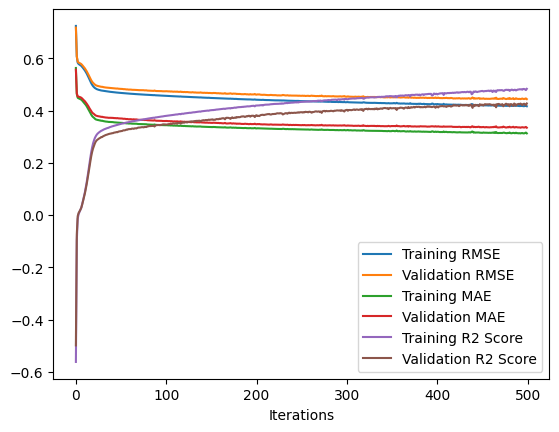

In [159]:
import matplotlib.pyplot as plt
plt.plot(list(range(ann.parameters['iterations'])), ann.rmse_train)
plt.plot((list(range(ann.parameters['iterations']))), ann.rmse_val)
plt.plot((list(range(ann.parameters['iterations']))), ann.mae_train)
plt.plot((list(range(ann.parameters['iterations']))), ann.mae_val)
plt.plot((list(range(ann.parameters['iterations']))), ann.r2_train)
plt.plot((list(range(ann.parameters['iterations']))), ann.r2_val)
plt.legend(['Training RMSE', 'Validation RMSE', 'Training MAE', 'Validation MAE', 'Training R2 Score', 'Validation R2 Score'])
plt.xlabel("Iterations")
plt.show()

In [155]:
ann2 = ANN(parameters = {"encoding": "OneHot", "num_PCA_comp": -1, "batch_size": 1, 'iterations': 500})
ann2.training_validation()

Number of Highly correlated features removes:  2
Features Removed:  {'Total Population - Female', 'IPPU'}

183
Epoch: 0 Training MAE: 0.48620814085006714 RMSE: 0.6368803381919861 R2: -0.20969162445369438
Epoch: 0 Validation MAE: 0.4867089092731476 RMSE: 0.633669912815094 R2: -0.16969671765233807

Epoch: 1 Training MAE: 0.4477211534976959 RMSE: 0.5793386697769165 R2: -0.000976789939159728
Epoch: 1 Validation MAE: 0.45327287912368774 RMSE: 0.5831530094146729 R2: 0.009368509051396745

Epoch: 2 Training MAE: 0.44480085372924805 RMSE: 0.5741172432899475 R2: 0.01698494375685833
Epoch: 2 Validation MAE: 0.4512542486190796 RMSE: 0.5793507695198059 R2: 0.022244538722228202

Epoch: 3 Training MAE: 0.4415225386619568 RMSE: 0.5695282220840454 R2: 0.03263683366595038
Epoch: 3 Validation MAE: 0.44867271184921265 RMSE: 0.5757081508636475 R2: 0.03450103269962013

Epoch: 4 Training MAE: 0.4376799762248993 RMSE: 0.5647989511489868 R2: 0.04863581152169916
Epoch: 4 Validation MAE: 0.4454297721385956 RMSE:

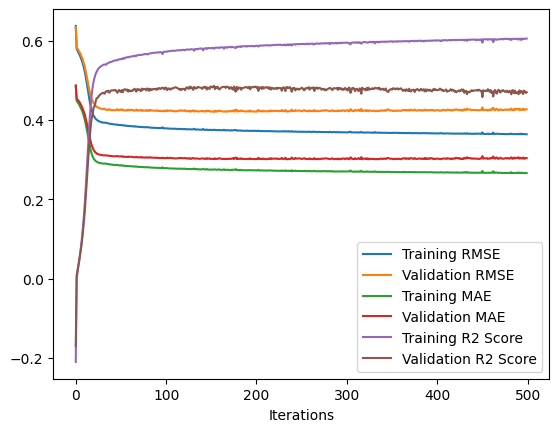

In [160]:
import matplotlib.pyplot as plt
plt.plot(list(range(ann2.parameters['iterations'])), ann2.rmse_train)
plt.plot((list(range(ann2.parameters['iterations']))), ann2.rmse_val)
plt.plot((list(range(ann2.parameters['iterations']))), ann2.mae_train)
plt.plot((list(range(ann2.parameters['iterations']))), ann2.mae_val)
plt.plot((list(range(ann2.parameters['iterations']))), ann2.r2_train)
plt.plot((list(range(ann2.parameters['iterations']))), ann2.r2_val)
plt.legend(['Training RMSE', 'Validation RMSE', 'Training MAE', 'Validation MAE', 'Training R2 Score', 'Validation R2 Score'])
plt.xlabel("Iterations")
plt.show()



---



Random Forest Regressor, Label Encoding, No PCA, Isolation Forest

In [165]:
model = Model(model = RandomForestRegressor(), parameters = {"encoding": "Label", "num_PCA_comp": -1, "outlier_detector": IsolationForest()}, kf = kf)
model.training_validation()

Number of Highly correlated features removes:  2
Features Removed:  {'Total Population - Female', 'IPPU'}

Number of outliers in the training set: 250
Number of outliers in the training set: 251
Number of outliers in the training set: 268
Number of outliers in the training set: 235
Number of outliers in the training set: 260
Train mean absolute error:  0.10430410728385955
Train root mean squared error:  0.14230615593062781
Train r2-score: 0.9405134276021835

Validation mean absolute error:  0.28350653835950923
Validation root mean squared error:  0.38458564816040514
Validation r2-score: 0.5600295725873755



In [168]:
model = Model(model = RandomForestRegressor(), parameters = {"encoding": "OneHot", "num_PCA_comp": -1, "outlier_detector": IsolationForest()}, kf = kf)
model.training_validation()

Number of Highly correlated features removes:  2
Features Removed:  {'Total Population - Female', 'IPPU'}

Number of outliers in the training set: 19
Number of outliers in the training set: 25
Number of outliers in the training set: 2
Number of outliers in the training set: 8
Number of outliers in the training set: 4
Train mean absolute error:  0.10285356628492755
Train root mean squared error:  0.1409752797539307
Train r2-score: 0.941105192433518

Validation mean absolute error:  0.2777999951363599
Validation root mean squared error:  0.37578737577329446
Validation r2-score: 0.5801578654076945



XGB Regressor, Label Encoding, No PCA, Isolation Forest

In [167]:
model = Model(model = XGBRegressor(), parameters = {"encoding": "Label", "num_PCA_comp": -1, "outlier_detector": IsolationForest()}, kf = kf)
model.training_validation()

Number of Highly correlated features removes:  2
Features Removed:  {'Total Population - Female', 'IPPU'}

Number of outliers in the training set: 240
Number of outliers in the training set: 258
Number of outliers in the training set: 212
Number of outliers in the training set: 194
Number of outliers in the training set: 208
Train mean absolute error:  0.08834686956746673
Train root mean squared error:  0.11745224343482734
Train r2-score: 0.9594489616356432

Validation mean absolute error:  0.28756775403460727
Validation root mean squared error:  0.3884257351620856
Validation r2-score: 0.5511715521628616



In [169]:
model = Model(model = XGBRegressor(), parameters = {"encoding": "OneHot", "num_PCA_comp": -1, "outlier_detector": IsolationForest()}, kf = kf)
model.training_validation()

Number of Highly correlated features removes:  2
Features Removed:  {'Total Population - Female', 'IPPU'}

Number of outliers in the training set: 21
Number of outliers in the training set: 20
Number of outliers in the training set: 8
Number of outliers in the training set: 15
Number of outliers in the training set: 21
Train mean absolute error:  0.10726342847396372
Train root mean squared error:  0.1422805398742716
Train r2-score: 0.9400274999817902

Validation mean absolute error:  0.27840617189844025
Validation root mean squared error:  0.37712425093175234
Validation r2-score: 0.5767057422437742



## Adding Additional Feature (Cluster ID) - Kmeans

In [185]:
model = Model(model = RandomForestRegressor(), parameters = {"encoding": "Label", "num_PCA_comp": -1, "additional_feature": True, "outlier_detector": None}, kf = kf)
model.training_validation()

Number of Highly correlated features removes:  2
Features Removed:  {'Total Population - Female', 'IPPU'}

Train mean absolute error:  0.1029289541742213
Train root mean squared error:  0.14086403975727774
Train r2-score: 0.9411050042506843

Validation mean absolute error:  0.27724322856589906
Validation root mean squared error:  0.37507966205463283
Validation r2-score: 0.5817092668853507



In [186]:
model = Model(model = XGBRegressor(), parameters = {"encoding": "Label", "num_PCA_comp": -1, "additional_feature": True, "outlier_detector": None}, kf = kf)
model.training_validation()

Number of Highly correlated features removes:  2
Features Removed:  {'Total Population - Female', 'IPPU'}

Train mean absolute error:  0.0884727107669114
Train root mean squared error:  0.11699745907209773
Train r2-score: 0.959330646723729

Validation mean absolute error:  0.2776655601822541
Validation root mean squared error:  0.3735054388924413
Validation r2-score: 0.5851113323643502

